# <b>데이터 전처리</b> Preprocessing

## <b>0.0 라이브러리</b>

### <b>0.1 사용 툴 / 라이브러리</b> (추후 정리)

In [1]:
# 로그 기록

import logging
logging.basicConfig(filename='./test.log', level=logging.DEBUG) #기본값은 warning (warning 이상의 로그만 출력됨)

# 로그 생성
logger = logging.getLogger()

# 로그의 출력 기준 설정
logger.setLevel(logging.DEBUG)

# log 출력 형식
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# log를 파일에 출력
file_handler = logging.FileHandler('my.log')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

logger.info("log info")

In [2]:
# 범용 라이브러리
import pandas as pd     # DataFrame, Series 및 데이터 분석
import numpy as np      # Array 및 
from tqdm import tqdm   # 진행상황 Progress Bar를 위한 tqdm library
import re               # Regular Expression 사용
import pickle           # 토큰화된 단어목록의 인덱스를 저장, 불러오기 위해 사용
from sklearn.model_selection import train_test_split # train, test split

# 토크나이징, 인코딩 관련 라이브러리
from eunjeon import Mecab           # Mecab 형태소 분석기의 한국어+윈도우용 버전인 은전한닢 프로젝트
from collections import Counter     
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# 그래프 관련 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
import platform


# 한글 폰트 설정
if (platform.system() == 'Windows'):
    plt.rc('font', family='Malgun Gothic')
else:
    plt.rc('font', family='AppleGothic')


# 음수(-)가 깨지는 현상 방지
plt.rcParams['axes.unicode_minus'] = False 

logger.info("log info")


## <b>1.0 데이터 불러오기</b>

In [7]:
# 실습용자료 불러와 csv로 저장

# train = pd.read_table("./data/1. 실습용자료.txt", encoding='CP949', sep='|') # 실습용자료의 구분자 '|'
# train.to_csv('./data/train.csv', index=False)


#  불러와 csv로 저장

# test = pd.read_table("./data/2. 모델개발용자료.txt", encoding='CP949', sep='|') # 모델개발용자료의 구분자 '|'
# test.to_csv('./data/test.csv', index=False)

# 데이터 불러오기

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

logger.info("log info")


In [8]:
# 한국표준산업분류 딕셔너리 생성

cat_dic = pd.read_excel('./data/한국표준산업분류(10차)_국문.xlsx').iloc[2:,0:6]

cat_dic.rename(columns={'개정 분류체계(제10차 기준)':'대분류', 'Unnamed: 1':'대분류명', 
                        'Unnamed: 2': '중분류', 'Unnamed: 3': '중분류명',
                        'Unnamed: 4': '소분류', 'Unnamed: 5': '소분류명'}, inplace=True)

digit_1_df = cat_dic[['대분류', '대분류명']].dropna().reset_index(drop=True) # 대분류 'A' ~ 'U'
digit_2_df = cat_dic[['중분류', '중분류명']].dropna().reset_index(drop=True) # 중분류 1 ~ 99
digit_3_df = cat_dic[['소분류', '소분류명']].dropna().reset_index(drop=True) # 소분류 11 ~ 990

digit_1_dict = {} # 대분류 딕셔너리
digit_2_dict = {} # 중분류 딕셔너리
digit_3_dict = {} # 소분류 딕셔너리

for i in tqdm(range(len(digit_1_df)+len(digit_2_df)+len(digit_3_df))):

    if i < len(digit_1_df):
        digit_1_dict[digit_1_df.iloc[i]['대분류']] = digit_1_df.iloc[i]['대분류명']

    if i < len(digit_2_df):
        digit_2_dict[int(digit_2_df.iloc[i]['중분류'])] = digit_2_df.iloc[i]['중분류명']

    if i < len(digit_3_df):
        digit_3_dict[int(digit_3_df.iloc[i]['소분류'])] = digit_3_df.iloc[i]['소분류명']


# 생성된 딕셔너리 결과 확인

print(digit_1_dict, '\n', digit_2_dict, '\n', digit_3_dict)


# 생성된 딕셔너리 피클로 저장

with open('./data/dictionary/digit_1_dict.pickle', 'wb') as handle:
    pickle.dump(digit_1_dict, handle)

with open('./data/dictionary/digit_2_dict.pickle', 'wb') as handle:
    pickle.dump(digit_2_dict, handle)

with open('./data/dictionary/digit_3_dict.pickle', 'wb') as handle:
    pickle.dump(digit_3_dict, handle)

logger.info("log info")

100%|██████████| 330/330 [00:00<00:00, 5862.90it/s]

{'A': '농업, 임업 및 어업(01~03)', 'B': '광업(05~08)', 'C': '제조업(10~34)', 'D': '전기, 가스, 증기 및 공기 조절 공급업(35)', 'E': '수도, 하수 및 폐기물 처리, 원료 재생업(36~39)', 'F': '건설업(41~42)', 'G': '도매 및 소매업(45~47)', 'H': '운수 및 창고업(49~52)', 'I': '숙박 및 음식점업(55~56)', 'J': '정보통신업(58~63)', 'K': '금융 및 보험업(64~66)', 'L': '부동산업(68)', 'M': '전문, 과학 및 기술 서비스업(70~73)', 'N': '사업시설 관리, 사업 지원 및 임대 서비스업(74~76)', 'O': '공공 행정, 국방 및 사회보장 행정(84)', 'P': '교육 서비스업(85)', 'Q': '보건업 및 사회복지 서비스업(86~87)', 'R': '예술, 스포츠 및 여가관련 서비스업(90~91)', 'S': '협회 및 단체, 수리 및 기타 개인 서비스업(94~96)', 'T': '가구 내 고용활동 및 달리 분류되지 않은 자가 소비 생산활동(97~98)', 'U': '국제 및 외국기관(99)'} 
 {1: '농업', 2: '임업', 3: '어업', 5: '석탄, 원유 및 천연가스 광업', 6: '금속 광업', 7: '비금속광물 광업; 연료용 제외', 8: '광업 지원 서비스업', 10: '식료품 제조업', 11: '음료 제조업', 12: '담배 제조업', 13: '섬유제품 제조업; 의복 제외', 14: '의복, 의복 액세서리 및 모피제품 제조업', 15: '가죽, 가방 및 신발 제조업', 16: '목재 및 나무제품 제조업; 가구 제외', 17: '펄프, 종이 및 종이제품 제조업', 18: '인쇄 및 기록매체 복제업', 19: '코크스, 연탄 및 석유정제품 제조업', 20: '화학 물질 및 화학제품 제조업; 의약품 제외', 21: '의료용 물질 및 의약품 제조업', 22: '고무 및 플라스틱제품 제조업', 23

## <b>2.0 데이터 탐색</b>

In [9]:
# head()로 첫 5줄 데이터 형태 및 컬럼 탐색

print(train.head(), '\n')

print(test.head())

# 일련번호(AI_id), 산업대분류(digit_1), 산업중분류(digit_2), 산업소분류(digit_3), 
# 사업 대상(text_obj), 사업 방법(text_mthd), 사업 취급품목(text_deal)

logger.info("log info")

        AI_id digit_1  digit_2  digit_3    text_obj    text_mthd text_deal
0  id_0000001       S       95      952       카센터에서      자동차부분정비   타이어오일교환
1  id_0000002       G       47      472       상점내에서    일반인을 대상으로   채소.과일판매
2  id_0000003       G       46      467  절단하여사업체에도매    공업용고무를가지고    합성고무도매
3  id_0000004       G       47      475       영업점에서      일반소비자에게    열쇠잠금장치
4  id_0000005       Q       87      872        어린이집  보호자의 위탁을 받아   취학전아동보육 

       AI_id  digit_1  digit_2  digit_3  text_obj  text_mthd text_deal
0  id_000001      NaN      NaN      NaN   치킨전문점에서   고객의주문에의해      치킨판매
1  id_000002      NaN      NaN      NaN      산업공구  다른 소매업자에게    철물 수공구
2  id_000003      NaN      NaN      NaN       절에서   신도을 대상으로    불교단체운영
3  id_000004      NaN      NaN      NaN     영업장에서      고객요구로     자동차튜닝
4  id_000005      NaN      NaN      NaN  실내포장마차에서  접객시설을 갖추고   소주,맥주제공


In [10]:
# info()

print(train.info(), '\n') # 전체 100만 건, text 컬럼들에 널값 존재, digit_2와 3 컬럼은 정수형 타입

print(test.info()) # 전체 100만 건, text 컬럼들에 널값 존재, digit(label) 컬럼들은 널값

logger.info("log info")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   AI_id      1000000 non-null  object
 1   digit_1    1000000 non-null  object
 2   digit_2    1000000 non-null  int64 
 3   digit_3    1000000 non-null  int64 
 4   text_obj   983323 non-null   object
 5   text_mthd  956381 non-null   object
 6   text_deal  932348 non-null   object
dtypes: int64(2), object(5)
memory usage: 53.4+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   AI_id      100000 non-null  object 
 1   digit_1    0 non-null       float64
 2   digit_2    0 non-null       float64
 3   digit_3    0 non-null       float64
 4   text_obj   98189 non-null   object 
 5   text_mthd  97032 non-null   object 
 6   text_deal  93839 non

### <b>2.1 시각적 EDA</b>

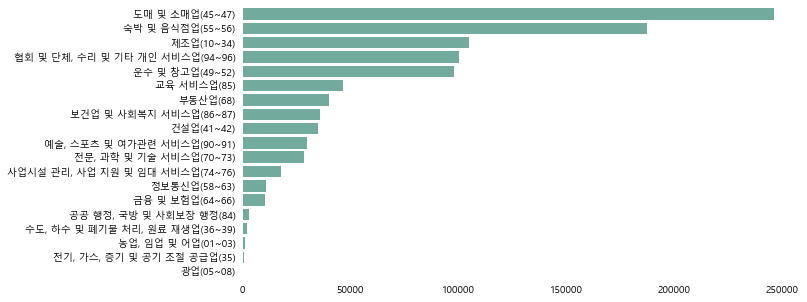

In [11]:
# 대분류 분포 그래프

digit_1_count = train.groupby(['digit_1'], as_index=False)['AI_id'].count()
digit_1_count.replace(digit_1_dict, inplace=True)

# Set the figure size
plot1 = plt.figure(figsize=(10, 5))

# plot a bar chart
sns.barplot(
    x = 'AI_id', y = 'digit_1',
    data = digit_1_count,
    estimator=sum, 
    ci=None, 
    order = list(digit_1_count.sort_values('AI_id', ascending=False)['digit_1']),
    color='#69b3a2');

# Hide spines and ticks
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tick_params(bottom=False)
plt.tick_params(left=False)
plt.xlabel("")
plt.ylabel("")

plt.show()

logger.info("log info")

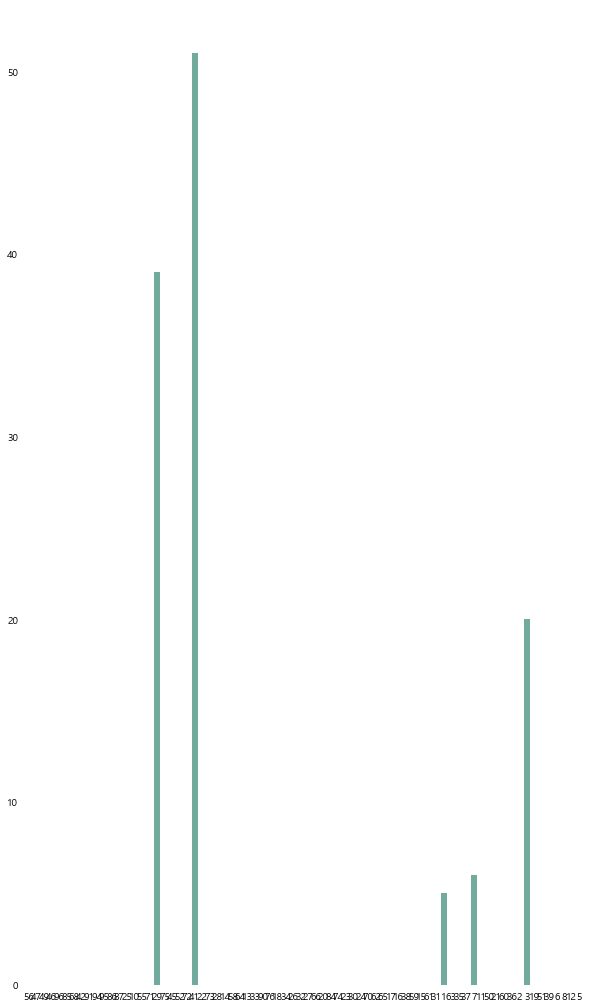

In [12]:
# 중분류 분포 그래프

digit_2_count = train.groupby(['digit_2'], as_index=False)['AI_id'].count()
digit_2_count['DDdigit_2'] = digit_2_count['digit_2'].replace(digit_2_dict)

# Set the figure size
plt.figure(figsize=(10, 18))

# plot a bar chart
sns.barplot(
    x = 'AI_id', y = 'digit_2',
    data = digit_2_count,
    estimator=sum, 
    ci=None, 
    order = list(digit_2_count.sort_values('AI_id', ascending=False)['digit_2']),
    color='#69b3a2');

# Hide spines and ticks
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tick_params(bottom=False)
plt.tick_params(left=False)
plt.xlabel("")
plt.ylabel("")


plt.show()

logger.info("log info")

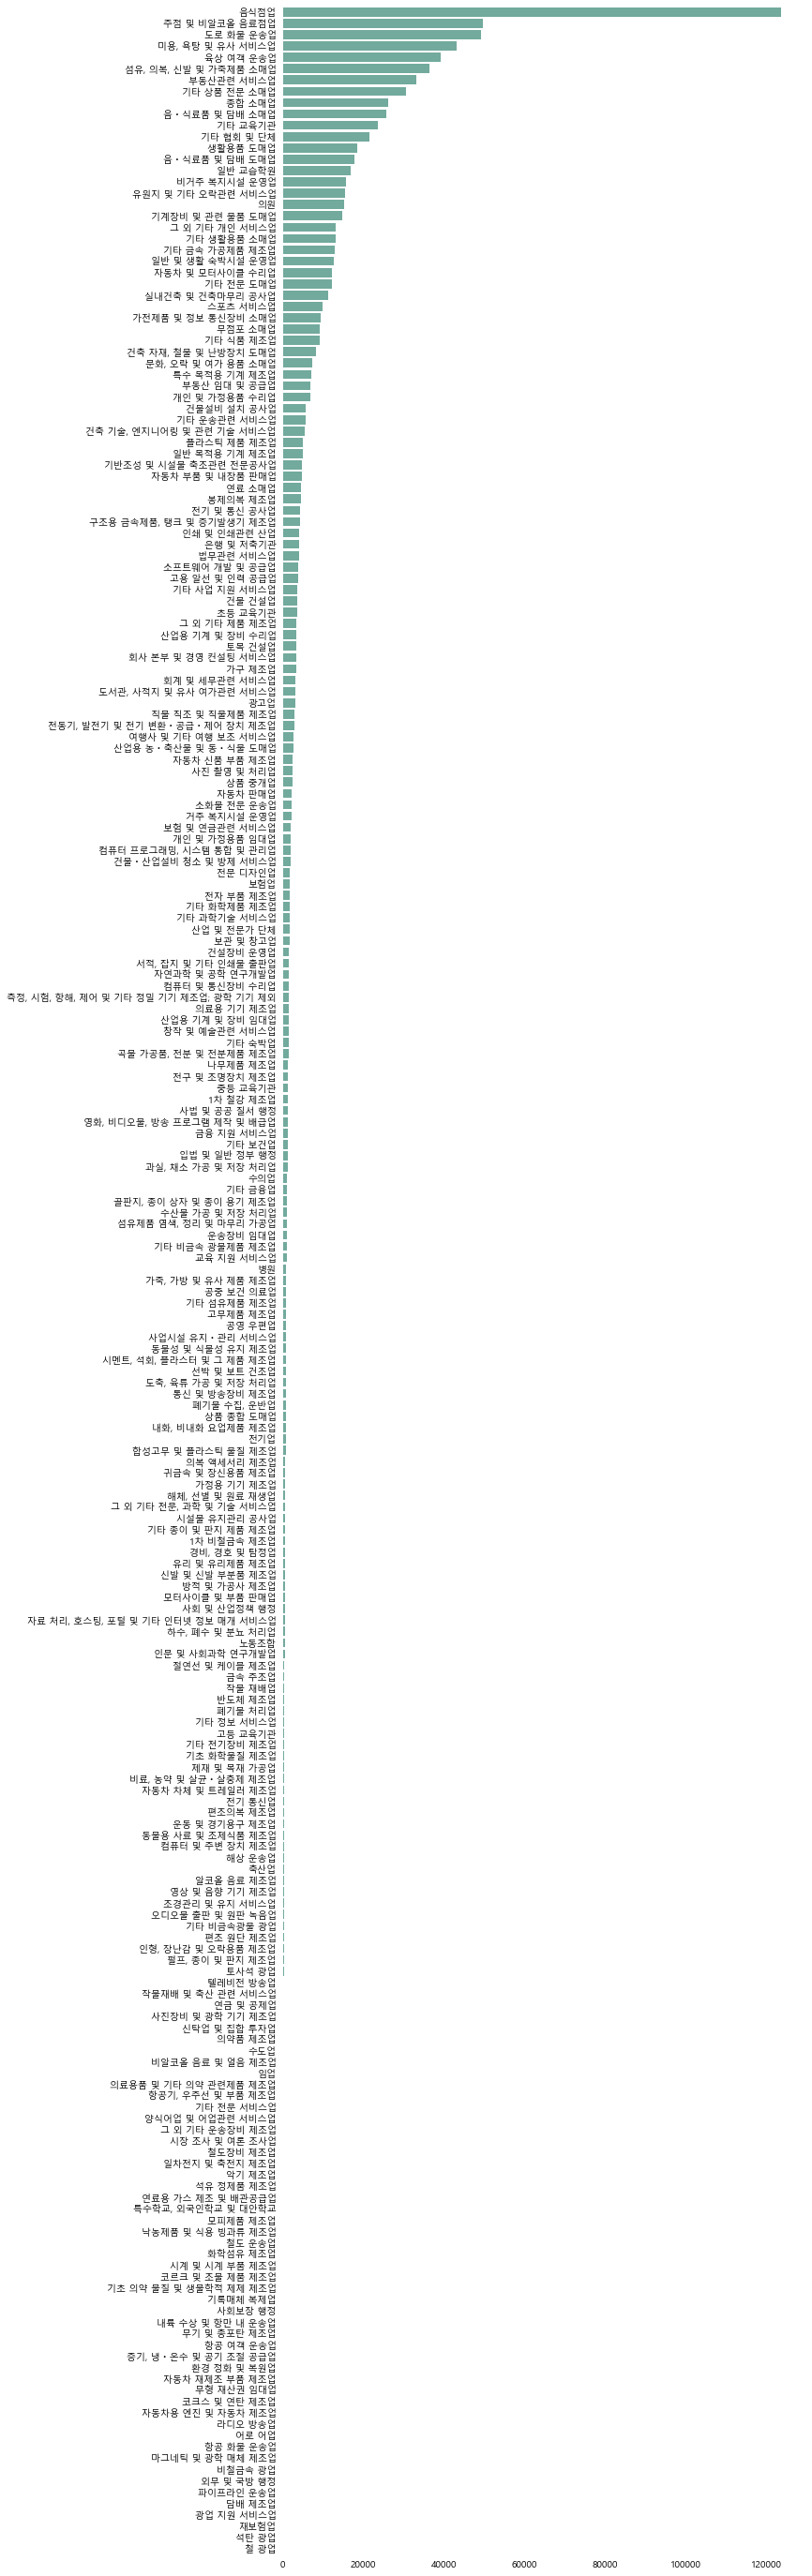

In [13]:
# 소분류 분포 그래프

digit_3_count = train.groupby(['digit_3'], as_index=False)['AI_id'].count()
digit_3_count['digit_3'] = digit_3_count['digit_3'].replace(digit_3_dict)

# Set the figure size
plt.figure(figsize=(10, 50))

# plot a bar chart
sns.barplot(
    x = 'AI_id', y = 'digit_3',
    data = digit_3_count,
    estimator=sum, 
    ci=None, 
    order = list(digit_3_count.sort_values('AI_id', ascending=False)['digit_3']),
    color='#69b3a2');

# Hide spines and ticks
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tick_params(bottom=False)
plt.tick_params(left=False)
plt.xlabel("")
plt.ylabel("")

plt.show()

logger.info("log info")

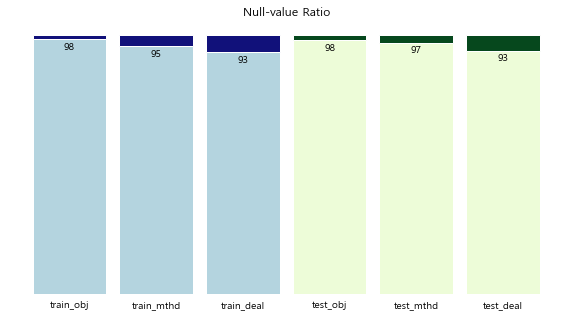

In [14]:
# 널값 비율 그래프

# Data
r1 , r2 = [0,1,2], [3,4,5] # for X row

train_data = {'notnull': [train['text_obj'].count(), train['text_mthd'].count(), train['text_deal'].count()],
            'isnull': [train['text_obj'].isnull().sum(), train['text_mthd'].isnull().sum(), train['text_deal'].isnull().sum()]}
test_data = {'notnull': [test['text_obj'].count(), test['text_mthd'].count(), test['text_deal'].count()],
            'isnull': [test['text_obj'].isnull().sum(), test['text_mthd'].isnull().sum(), test['text_deal'].isnull().sum()]}

train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)
 
# From raw value to percentage
train_totals = [i+j for i,j in zip(train_data['notnull'], train_data['isnull'])] # for train
train_notnull = [i / j * 100 for i,j in zip(train_data['notnull'], train_totals)]
train_isnull = [i / j * 100 for i,j in zip(train_data['isnull'], train_totals)]

test_totals = [i+j for i,j in zip(test_data['notnull'], test_data['isnull'])] # for test
test_notnull = [i / j * 100 for i,j in zip(test_data['notnull'], test_totals)]
test_isnull = [i / j * 100 for i,j in zip(test_data['isnull'], test_totals)]
 
# plot
plt.figure(figsize=(10, 5))
barWidth = 0.85

# Create train bars
plot1 = plt.bar(r1, train_notnull, color='#B4D4DF', edgecolor='white', width=barWidth)
plt.bar(r1, train_isnull, bottom=train_notnull, color='#11117A', edgecolor='white', width=barWidth)

# Create text bars
plot2 = plt.bar(r2, test_notnull, color='#EDFCD8', edgecolor='white', width=barWidth)
plt.bar(r2, test_isnull, bottom=test_notnull, color='#06481D', edgecolor='white', width=barWidth)

# Custom x axis
names = ('train_obj','train_mthd','train_deal','test_obj','test_mthd', 'test_deal')
plt.xticks(r1+r2, names)

for value in plot1:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             0.95*height,'%d' % int(height), ha='center', va='bottom')

for value in plot2:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             0.95*height,'%d' % int(height), ha='center', va='bottom')

# Hide spines and ticks
ax = plt.gca()
ax.axes.yaxis.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tick_params(bottom=False)

# Title
plt.title("Null-value Ratio")

# Show graphic
plt.show()

logger.info("log info")

## <b>3.0 데이터 정제</b>

### <b>~~구두점, 오타 제거~~</b>

In [17]:
# 구두점, 오타(ㅋ, ㅡ 등 한글자) 제거

for col in tqdm(train[['text_obj', 'text_mthd', 'text_deal']].columns):
    train[col] = train[col].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-z ]',' ', regex=True).str.replace('[* , .]', ' ', regex=True)
    test[col] = test[col].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-z ]','', regex=True).str.replace('[* , .]', ' ', regex=True)
    
logger.info("log info")

100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


### <b>결측치 처리</b>

In [18]:
# 결측값 탐색

condition1 = train['text_obj'].isnull() == True
condition2 = train['text_mthd'].isnull() == True
condition3 = train['text_deal'].isnull() == True

print("세 컬럼 모두 널 값인 경우: ", len(train[condition1&condition2&condition3])) # 세 컬럼 모두 Null 값인 로우는 없음.
print("obj 컬럼 널 값인 경우: ", len(train[condition1]))
print("mthd 컬럼 널 값인 경우: ", len(train[condition2]))
print("deal 컬럼 널 값인 경우: ", len(train[condition3]))


# 결측치를 ""로 대치 

train.fillna("",inplace=True)
test.fillna("", inplace=True)

logger.info("log info")

세 컬럼 모두 널 값인 경우:  0
obj 컬럼 널 값인 경우:  16677
mthd 컬럼 널 값인 경우:  43619
deal 컬럼 널 값인 경우:  67652


## <b>4.0 토큰화</b>

In [19]:
# 작성해둔 한국어 불용어 사전 불러오기

stopwords = pd.read_csv("./data/stopwords/stopwords.csv", encoding='CP949')
stopwords = stopwords['stopwords']
print(stopwords, len(stopwords))

logger.info("log info")

0        고
1        업
2        아
3        휴
4      아이구
      ... 
661      원
662      잘
663     통하
664     소리
665      놓
Name: stopwords, Length: 666, dtype: object 666


### Mecab 토크나이징

In [20]:
# train 데이터 토크나이징

mecab_train_text_obj = []
mecab_train_text_mthd = []
mecab_train_text_deal = []

mecab = Mecab()

for sentence in tqdm(train['text_obj']): # 진행상황 Progress Bar를 위한 tqdm library
    tokenized_sentence = mecab.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in list(stopwords)] # 불용어 제거
    mecab_train_text_obj.append(stopwords_removed_sentence)

for sentence in tqdm(train['text_mthd']):
    tokenized_sentence = mecab.morphs(sentence) 
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in list(stopwords)] # 불용어 제거
    mecab_train_text_mthd.append(stopwords_removed_sentence)

for sentence in tqdm(train['text_deal']):
    tokenized_sentence = mecab.morphs(sentence) 
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in list(stopwords)] # 불용어 제거
    mecab_train_text_deal.append(stopwords_removed_sentence)

logger.info("log info")

100%|██████████| 1000000/1000000 [05:35<00:00, 2983.83it/s]


In [21]:
# test 데이터 토크나이징

mecab_test_text_obj = []
mecab_test_text_mthd = []
mecab_test_text_deal = []

mecab = Mecab()

for sentence in tqdm(test['text_obj']): # 진행상황 Progress Bar를 위한 tqdm library
    tokenized_sentence = mecab.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in list(stopwords)] # 불용어 제거
    mecab_test_text_obj.append(stopwords_removed_sentence)

for sentence in tqdm(test['text_mthd']):
    tokenized_sentence = mecab.morphs(sentence)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in list(stopwords)] # 불용어 제거
    mecab_test_text_mthd.append(stopwords_removed_sentence)

for sentence in tqdm(test['text_deal']): 
    tokenized_sentence = mecab.morphs(sentence) 
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in list(stopwords)] # 불용어 제거
    mecab_test_text_deal.append(stopwords_removed_sentence)
    
logger.info("log info")

100%|██████████| 100000/100000 [00:38<00:00, 2612.20it/s]


In [23]:
# 토큰화된 결과 합쳐 text 컬럼으로 생성

# train 데이터
train['text'] = mecab_train_text_obj
train['text'] = train['text'] + mecab_train_text_mthd
train['text'] = train['text'] + mecab_train_text_deal

# test 데이터
test['text'] = mecab_test_text_obj
test['text'] = test['text'] + mecab_test_text_mthd
test['text'] = test['text'] + mecab_test_text_deal

logger.info("log info")

C:\Users\Huitaek\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return op(a, b)


In [24]:
# mecab 형태소 분석기로 토큰화된 데이터 사용하기 편하도록 csv 파일로 저장

X_train = train.drop(columns=['text_obj', 'text_mthd', 'text_deal'])
X_train.to_csv('./data/mecab/tokenized_train.csv', encoding='CP949', index=False)

X_test = test.drop(columns=['text_obj', 'text_mthd', 'text_deal'])
X_test.to_csv('./data/mecab/tokenized_test.csv', encoding='CP949', index=False)

logger.info("log info")

### <b>토큰화 결과 EDA</b>

In [25]:
# 대분류 빈도수 카운트

for i in list(X_train['digit_1'].unique()):
    print('<',digit_1_dict[i],'>')
    cat_words = np.hstack(X_train[X_train['digit_1'] == i]['text'].values)
    cat_words_count = Counter(cat_words)
    print(cat_words_count.most_common(20), '\n')

logger.info("log info")

< 협회 및 단체, 수리 및 기타 개인 서비스업(94~96) >
[('대상', 41820), ('서비스', 40015), ('고객', 31272), ('종교', 25880), ('일반인', 17269), ('미용실', 15414), ('염색', 15149), ('수리', 14153), ('활동', 14064), ('미용', 13828), ('파마', 13729), ('교회', 13073), ('일반', 12459), ('사업장', 11730), ('기독교', 10748), ('발', 10118), ('자동차', 10104), ('계통', 9532), ('컷트', 8129), ('제공', 7383)] 

< 도매 및 소매업(45~47) >
[('일반', 82910), ('소비자', 78369), ('소매', 74629), ('대상', 70956), ('매장', 65071), ('판매', 61918), ('사업장', 49553), ('도매', 47526), ('일반인', 34993), ('고객', 22324), ('소매업자', 22128), ('의류', 19612), ('가게', 14843), ('용품', 13044), ('산업', 12483), ('사용자', 11340), ('영업장', 10905), ('여성', 10644), ('편의점', 10251), ('음식료품', 9715)] 

< 보건업 및 사회복지 서비스업(86~87) >
[('환자', 15135), ('외래', 12553), ('진료', 12085), ('서비스', 12083), ('위주', 10732), ('의원', 9952), ('대상', 9215), ('어린이', 8279), ('보육', 7567), ('치과', 7141), ('유아', 5957), ('취학전', 5536), ('노인', 5502), ('복지', 4969), ('요양', 4557), ('위탁', 4317), ('아동', 4310), ('보호자', 3721), ('치료', 3276), ('시설', 3269)] 

< 제조업(10

In [26]:
# 중분류 빈도수 카운트

for i in list(X_train['digit_2'].unique()):
    print('<',digit_2_dict[i],'>')
    cat_words = np.hstack(X_train[X_train['digit_2'] == i]['text'].values)
    cat_words_count = Counter(cat_words)
    print(cat_words_count.most_common(20), '\n')

logger.info("log info")

< 개인 및 소비용품 수리업 >
[('수리', 14119), ('자동차', 10067), ('고객', 8874), ('대상', 6871), ('수선', 5766), ('서비스', 4340), ('사업장', 4213), ('카센타', 3995), ('부분', 3736), ('특정', 3318), ('전문', 3176), ('정비', 2934), ('경정비', 2777), ('일반인', 2775), ('요청', 2727), ('옷', 2193), ('일반', 2079), ('타이어', 1986), ('세차', 1850), ('의뢰', 1767)] 

< 소매업; 자동차 제외 >
[('일반', 76537), ('소비자', 74892), ('소매', 70691), ('대상', 55496), ('매장', 53288), ('판매', 49386), ('일반인', 32378), ('사업장', 19399), ('고객', 16740), ('의류', 16514), ('가게', 13006), ('편의점', 10229), ('음식료품', 9677), ('여성', 9499), ('용품', 8835), ('위주', 8053), ('식료품', 7267), ('체인', 6674), ('계약', 6599), ('화장품', 6579)] 

< 도매 및 상품 중개업 >
[('도매', 46025), ('사업장', 27742), ('소매업자', 21584), ('대상', 12321), ('산업', 12003), ('사용자', 10875), ('매장', 10270), ('판매', 9428), ('영업장', 4658), ('일반', 4372), ('도소매', 3588), ('상가', 3491), ('고객', 3488), ('용품', 3400), ('의류', 3096), ('수집', 3079), ('업체', 2995), ('기계', 2957), ('부품', 2912), ('고철', 2887)] 

< 사회복지 서비스업 >
[('어린이', 8239), ('보육', 7567), ('유아', 5934), ('

In [27]:
# 소분류 빈도수 카운트

for i in list(X_train['digit_3'].unique()):
    print('<',digit_3_dict[i],'>')
    cat_words = np.hstack(X_train[X_train['digit_3'] == i]['text'].values)
    cat_words_count = Counter(cat_words)
    print(cat_words_count.most_common(20), '\n')

logger.info("log info")

< 자동차 및 모터사이클 수리업 >
[('자동차', 10067), ('수리', 9289), ('고객', 5052), ('대상', 4688), ('카센타', 3995), ('부분', 3663), ('특정', 3260), ('정비', 2927), ('전문', 2875), ('서비스', 2823), ('경정비', 2777), ('사업장', 2184), ('타이어', 1983), ('세차', 1850), ('내장', 1437), ('일반인', 1302), ('차량', 1301), ('만', 1280), ('카센터', 1139), ('일반', 1041)] 

< 음ㆍ식료품 및 담배 소매업 >
[('소비자', 14023), ('일반', 13523), ('소매', 11326), ('대상', 9116), ('판매', 8405), ('매장', 6058), ('일반인', 5402), ('가게', 4453), ('사업장', 3422), ('돼지고기', 2871), ('정육점', 2471), ('소고기', 2258), ('고객', 2211), ('과일', 2067), ('반찬', 1876), ('식품', 1840), ('수산물', 1668), ('채소', 1536), ('건강', 1426), ('영업장', 1309)] 

< 기타 전문 도매업 >
[('도매', 5933), ('사업장', 4188), ('수집', 3040), ('고철', 2878), ('판매', 2630), ('산업', 2289), ('사용자', 2040), ('대상', 1511), ('고물상', 1473), ('소매업자', 1408), ('비철', 1347), ('재생', 1204), ('매장', 1107), ('농약', 929), ('원단', 882), ('금속', 815), ('고물', 804), ('비료', 794), ('폐지', 730), ('재', 632)] 

< 기타 생활용품 소매업 >
[('일반', 6897), ('소매', 6697), ('소비자', 6584), ('대상', 4502), ('매장', 

## <b>5.0 인코딩</b>

In [28]:
X_train = pd.read_csv('./data/mecab/tokenized_train.csv', encoding='CP949')

y_train = X_train[['digit_1', 'digit_2', 'digit_3']]
X_train = X_train['text']

logger.info("log info")

In [29]:
X_test = pd.read_csv('./data/mecab/tokenized_test.csv', encoding='CP949')
X_test = X_test['text']

logger.info("log info")

In [30]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

threshold = 1 # 등장 빈도 수의 threshold
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

# 전체 단어 개수 중 빈도수 0 인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

logger.info("log info")

단어 집합(vocabulary)의 크기 : 35701
등장 빈도가 0번 이하인 희귀 단어의 수: 0
단어 집합에서 희귀 단어의 비율: 0.0
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.0
단어 집합의 크기 : 35702


In [31]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)

logger.info("log info")

In [32]:
X_test = tokenizer.texts_to_sequences(X_test)

logger.info("log info")

In [33]:
# Tokenizer 객체에 담긴 어휘 분석 정보가 현재 폴더의 tokenizer.pickle에 저장

with open('./data/mecab/tokenizer.pickle', 'wb') as handle:
     pickle.dump(tokenizer, handle)

logger.info("log info")

## <b>6.0 패딩</b>

리뷰의 최대 길이 : 27
리뷰의 평균 길이 : 6.153836


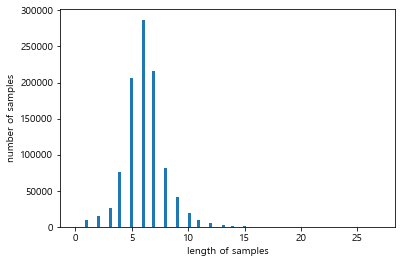

전체 샘플 중 길이가 10 이하인 샘플의 비율: 98.0321


In [34]:
# max_len 결정

print('리뷰의 최대 길이 :',max(len(word) for word in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

plt.hist([len(word) for word in X_train], bins=100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))
    
max_len = 10
below_threshold_len(max_len, X_train)

logger.info("log info")

In [35]:
# max_len 에 맞게 데이터셋 패딩

X_train = pad_sequences(X_train, maxlen=max_len)

X_test = pad_sequences(X_test, maxlen=max_len)

logger.info("log info")

In [36]:
# stratify split을 위해 개수가 1이라 나눌 수 없는 케이스 탐색

print(y_train.groupby(['digit_2'])['digit_2'].count().sort_values())

print(y_train.groupby(['digit_3'])['digit_3'].count().sort_values())

logger.info("log info")

digit_2
5          1
8          3
12         3
6          7
39        29
       ...  
96     56210
46     76835
49     90486
47    162202
56    173459
Name: digit_2, Length: 74, dtype: int64
digit_3
51          1
61          1
652         2
120         3
495         3
        ...  
492     39176
961     43040
493     49115
562     49756
561    123703
Name: digit_3, Length: 225, dtype: int64


In [37]:
condition = y_train['digit_2']==5
y_train[condition]

logger.info("log info")

In [38]:
condition = y_train['digit_3'] == 61
y_train[condition]

logger.info("log info")

In [39]:
condition = y_train['digit_3'] == 51
y_train[condition]

logger.info("log info")

In [40]:
temp_436664 = y_train.iloc[[436664]]
temp_436664

logger.info("log info")

In [41]:
temp_52203 = y_train.iloc[[52203]]
temp_52203

logger.info("log info")

In [42]:
y_train.drop(y_train.index[436664], inplace=True)
y_train.drop(y_train.index[52203], inplace=True)

logger.info("log info")

In [43]:
X_train = pd.DataFrame(X_train)

X_train.iloc[[436664, 52203]]

temp_436664_x = X_train.iloc[[436664]]

temp_52203_x = X_train.iloc[[52203]]

X_train.drop(X_train.index[436664], inplace=True)
X_train.drop(X_train.index[52203], inplace=True)

X_train = np.array(X_train)

logger.info("log info")

In [44]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size= 0.2, stratify=y_train, random_state=34)

logger.info("log info")

In [45]:
print(len(X_train), len(X_valid), len(y_train), len(y_valid))

logger.info("log info")

799998 200000 799998 200000


In [46]:
X_train = pd.DataFrame(X_train)

X_train = pd.concat([X_train, temp_436664_x, temp_52203_x])

X_train.reset_index(inplace=True, drop=True)

logger.info("log info")

In [47]:
X_train

logger.info("log info")

In [48]:
X_train = np.array(X_train)

logger.info("log info")

In [49]:
y_train = pd.concat([y_train, temp_436664, temp_52203])

y_train.reset_index(inplace=True, drop=True)

y_train

logger.info("log info")

In [50]:
# 데이터 셋 저장

pd.DataFrame(X_train).to_csv('./data/mecab/X_train.csv', encoding='CP949', index=False)
pd.DataFrame(X_valid).to_csv('./data/mecab/X_valid.csv', encoding='CP949', index=False)
pd.DataFrame(X_test).to_csv('./data/mecab/X_test.csv', encoding='CP949', index=False)
y_train.to_csv('./data/mecab/y_train.csv', encoding='CP949', index=False)
y_valid.to_csv('./data/mecab/y_valid.csv', encoding='CP949', index=False)

print(len(X_train), len(X_valid), len(y_train), len(y_valid), len(X_test))

logger.info("log info")

800000 200000 800000 200000 100000


# LSTM

## 라이브러리

In [51]:
import pandas as pd
import numpy as np
import re               # Regular Expression
import pickle           # 토큰화된 단어목록의 인덱스를 저장, 불러오기 위해 사용
from tqdm import tqdm   # 진행상황 Progress Bar를 위한 tqdm library

# 토크나이징/인코딩 관련 라이브러리
from eunjeon import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing

# 모델링 관련 라이브러리
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 그래프 관련 라이브러리
import matplotlib.pyplot as plt
import platform

# 한글 폰트 설정
if (platform.system() == 'Windows'):
    plt.rc('font', family='Malgun Gothic')
else:
    plt.rc('font', family='AppleGothic')

# 음수(-)가 깨지는 현상 방지
plt.rcParams['axes.unicode_minus'] = False 

logger.info("log info")

데이터 불러오기

In [52]:
# 전처리 및 분할된 데이터셋 불러오기

X_train = np.array(pd.read_csv('./data/mecab/X_train.csv'))
y_train_1 = pd.DataFrame(pd.read_csv('./data/mecab/y_train.csv')['digit_1'])
y_train_2 = pd.DataFrame(pd.read_csv('./data/mecab/y_train.csv')['digit_2'].astype(object))
y_train_3 = pd.DataFrame(pd.read_csv('./data/mecab/y_train.csv')['digit_3'].astype(object))

X_valid = np.array(pd.read_csv('./data/mecab/X_valid.csv'))
y_valid_1 =  pd.DataFrame(pd.read_csv('./data/mecab/y_valid.csv')['digit_1'])
y_valid_2 =  pd.DataFrame(pd.read_csv('./data/mecab/y_valid.csv')['digit_2'].astype(object))
y_valid_3 =  pd.DataFrame(pd.read_csv('./data/mecab/y_valid.csv')['digit_3'].astype(object))

X_test = np.array(pd.read_csv('./data/mecab/X_test.csv'))


# 저장된 Tokenizer 객체를 불러오는 부분

with open('./data/mecab/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

logger.info("log info")

In [53]:
# 한국표준산업분류 딕셔너리 불러오기

with open('./data/dictionary/digit_1_dict.pickle', 'rb') as handle:
    digit_1_dict = pickle.load(handle)

with open('./data/dictionary/digit_2_dict.pickle', 'rb') as handle:
    digit_2_dict = pickle.load(handle)

with open('./data/dictionary/digit_3_dict.pickle', 'rb') as handle:
    digit_3_dict = pickle.load(handle)

# 레이블 인코딩을 위한 산업분류 리스트, 데이터 프레임 만들기

digit_1_list = list(digit_1_dict.keys())
digit_1_df = pd.DataFrame([], columns=['digit_1'], index=[0])
for i in range(0, len(digit_1_dict)):
    digit_1_df.loc[i, 'digit_1'] = digit_1_list[i]

digit_2_list = list(digit_2_dict.keys())
digit_2_df = pd.DataFrame([], columns=['digit_2'], index=[0])
for i in range(0, len(digit_2_dict)):
    digit_2_df.loc[i, 'digit_2'] = digit_2_list[i]

digit_3_list = list(digit_3_dict.keys())
digit_3_df = pd.DataFrame([], columns=['digit_3'], index=[0])
for i in range(0, len(digit_3_dict)):
    digit_3_df.loc[i, 'digit_3'] = digit_3_list[i]

logger.info("log info")

### 인코딩

In [54]:
# 대분류 원-핫 인코딩

ohe1 = preprocessing.OneHotEncoder(sparse=False, dtype=int)
ohe1.fit(digit_1_df)

y_train_1 = ohe1.transform(y_train_1)
y_valid_1 = ohe1.transform(y_valid_1)

# ohe1 객체에 담긴 인코딩 정보가 ohe1.pickle에 저장
with open('./data/mecab/ohe1.pickle', 'wb') as handle:
    pickle.dump(ohe1, handle)


# 중분류 원-핫 인코딩

ohe2 = preprocessing.OneHotEncoder(sparse=False, dtype=int)
ohe2.fit(digit_2_df)

y_train_2 = ohe2.transform(y_train_2)
y_valid_2 = ohe2.transform(y_valid_2)

# ohe2 객체에 담긴 인코딩 정보가 ohe2.pickle에 저장
with open('./data/mecab/ohe2.pickle', 'wb') as handle:
    pickle.dump(ohe2, handle)


# 소분류 원-핫 인코딩

ohe3 = preprocessing.OneHotEncoder(sparse=False, dtype=int)
ohe3.fit(digit_3_df)

y_train_3 = ohe3.transform(y_train_3)
y_valid_3 = ohe3.transform(y_valid_3)

# ohe3 객체에 담긴 인코딩 정보가 ohe3.pickle에 저장
with open('./data/mecab/ohe3.pickle', 'wb') as handle:
    pickle.dump(ohe3, handle)

logger.info("log info")

## 대분류

Epoch 1/20
8000/8000 [==============================] - 93s 11ms/step - loss: 0.3314 - acc: 0.9132 - val_loss: 0.1256 - val_acc: 0.9673

Epoch 00001: val_acc improved from -inf to 0.96730, saving model to mecab_d1_ed10_hu10_sftmx_cc.h5
Epoch 2/20
8000/8000 [==============================] - 88s 11ms/step - loss: 0.1066 - acc: 0.9718 - val_loss: 0.1106 - val_acc: 0.9703

Epoch 00002: val_acc improved from 0.96730 to 0.97027, saving model to mecab_d1_ed10_hu10_sftmx_cc.h5
Epoch 3/20
8000/8000 [==============================] - 89s 11ms/step - loss: 0.0912 - acc: 0.9754 - val_loss: 0.1067 - val_acc: 0.9710

Epoch 00003: val_acc improved from 0.97027 to 0.97102, saving model to mecab_d1_ed10_hu10_sftmx_cc.h5
Epoch 4/20
8000/8000 [==============================] - 86s 11ms/step - loss: 0.0829 - acc: 0.9773 - val_loss: 0.1054 - val_acc: 0.9712

Epoch 00004: val_acc improved from 0.97102 to 0.97124, saving model to mecab_d1_ed10_hu10_sftmx_cc.h5
Epoch 5/20
8000/8000 [=========================

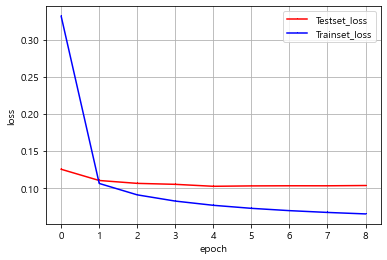

In [55]:
embedding_dim = len(X_train[0])
hidden_units = len(X_train[0])
vocab_size = 35721

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(len(y_train_1[0]), activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('./data/model/mecab_d1_ed{}_hu{}_sftmx_cc.h5'.format(embedding_dim, hidden_units), monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train_1, epochs=20, callbacks=[es, mc], batch_size=100, validation_data=(X_valid, y_valid_1))


# 그래프 생성

y_test_loss = history.history['val_loss']
y_train_loss = history.history['loss']

x_len = np.arange(len(y_test_loss))

plt.plot (x_len, y_test_loss, marker=',', c='red', label='Testset_loss')
plt.plot(x_len, y_train_loss, marker=',', c='blue', label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

logger.info("log info")

In [56]:
loaded_model = load_model('./data/model/mecab_d1_ed{}_hu{}_sftmx_cc.h5'.format(embedding_dim, hidden_units))
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_valid, y_valid_1)[1]))

logger.info("log info")

6250/6250 [==============================] - 17s 3ms/step - loss: 0.1027 - acc: 0.9721

 테스트 정확도: 0.9721


## 중분류

Epoch 1/20
8000/8000 [==============================] - 97s 12ms/step - loss: 0.8917 - acc: 0.7889 - val_loss: 0.4049 - val_acc: 0.9019

Epoch 00001: val_acc improved from -inf to 0.90192, saving model to ./data/model\mecab_d2_ed10_hu10_sftmx_cc.h5
Epoch 2/20
8000/8000 [==============================] - 95s 12ms/step - loss: 0.3274 - acc: 0.9187 - val_loss: 0.3074 - val_acc: 0.9232

Epoch 00002: val_acc improved from 0.90192 to 0.92325, saving model to ./data/model\mecab_d2_ed10_hu10_sftmx_cc.h5
Epoch 3/20
8000/8000 [==============================] - 97s 12ms/step - loss: 0.2627 - acc: 0.9327 - val_loss: 0.2823 - val_acc: 0.9278

Epoch 00003: val_acc improved from 0.92325 to 0.92783, saving model to ./data/model\mecab_d2_ed10_hu10_sftmx_cc.h5
Epoch 4/20
8000/8000 [==============================] - 93s 12ms/step - loss: 0.2359 - acc: 0.9388 - val_loss: 0.2745 - val_acc: 0.9300

Epoch 00004: val_acc improved from 0.92783 to 0.93001, saving model to ./data/model\mecab_d2_ed10_hu10_sftmx_c

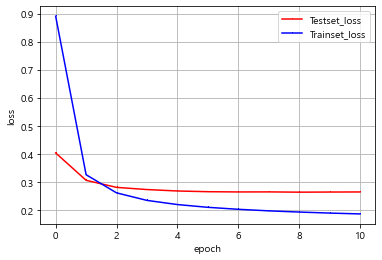

In [58]:
embedding_dim = len(X_train[0])
hidden_units = len(X_train[0])
vocab_size = 35721

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(len(y_train_2[0]), activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('./data/model/mecab_d2_ed{}_hu{}_sftmx_cc.h5'.format(embedding_dim, hidden_units), monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train_2, epochs=20, callbacks=[es, mc], batch_size=100, validation_data=(X_valid, y_valid_2))


y_test_loss = history.history['val_loss']
y_train_loss = history.history['loss']

x_len = np.arange(len(y_test_loss))

plt.plot (x_len, y_test_loss, marker=',', c='red', label='Testset_loss')
plt.plot(x_len, y_train_loss, marker=',', c='blue', label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

logger.info("log info")

In [60]:
loaded_model = load_model('./data/model/mecab_d2_ed{}_hu{}_sftmx_cc.h5'.format(embedding_dim, hidden_units))
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_valid, y_valid_2)[1]))

logger.info("log info")

6250/6250 [==============================] - 21s 3ms/step - loss: 0.2656 - acc: 0.9317: 0s - loss: 0.2657 - acc:

 테스트 정확도: 0.9317


## 소분류

In [62]:
vocab_size = 35703
embedding_dim = len(X_train[0])
hidden_units = len(X_train[0])

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(232, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('./data/model/mecab_d3_ed{}_hu{}_sftmx_cc.h5'.format(embedding_dim, hidden_units), monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train_3, epochs=20, callbacks=[es, mc], batch_size=100, validation_data=(X_valid, y_valid_3))

y_test_loss = history.history['val_loss']
y_train_loss = history.history['loss']

x_len = np.arange(len(y_test_loss))

plt.plot (x_len, y_test_loss, marker=',', c='red', label='Testset_loss')
plt.plot(x_len, y_train_loss, marker=',', c='blue', label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

logger.info("log info")

Epoch 1/20
8000/8000 [==============================] - 111s 14ms/step - loss: 1.9345 - acc: 0.5476 - val_loss: 0.9060 - val_acc: 0.7969

Epoch 00001: val_acc improved from -inf to 0.79693, saving model to ./data/model\mecab_d3_ed10_hu10_sftmx_cc.h5
Epoch 2/20
8000/8000 [==============================] - 100s 13ms/step - loss: 0.7066 - acc: 0.8368 - val_loss: 0.6177 - val_acc: 0.8563

Epoch 00002: val_acc improved from 0.79693 to 0.85629, saving model to ./data/model\mecab_d3_ed10_hu10_sftmx_cc.h5
Epoch 3/20
8000/8000 [==============================] - 104s 13ms/step - loss: 0.5360 - acc: 0.8737 - val_loss: 0.5349 - val_acc: 0.8741

Epoch 00003: val_acc improved from 0.85629 to 0.87413, saving model to ./data/model\mecab_d3_ed10_hu10_sftmx_cc.h5
Epoch 4/20
8000/8000 [==============================] - 100s 13ms/step - loss: 0.4668 - acc: 0.8884 - val_loss: 0.4987 - val_acc: 0.8819

Epoch 00004: val_acc improved from 0.87413 to 0.88187, saving model to ./data/model\mecab_d3_ed10_hu10_sft

KeyboardInterrupt: 

In [63]:
loaded_model = load_model('./data/model/mecab_d3_ed{}_hu{}_sftmx_cc.h5'.format(embedding_dim, hidden_units))
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_valid, y_valid_3)[1]))

logger.info("log info")

6250/6250 [==============================] - 24s 4ms/step - loss: 0.4418 - acc: 0.8941: 3s - loss: 0.4432 -  - ETA: 2s - loss: 0.4418 - E - ETA: 0s - loss: 0.4421 - 

 테스트 정확도: 0.8941


## 최종 예측 모델 결합, 답안 제출

In [64]:
X_test = np.array(pd.read_csv('./data/mecab/X_test.csv'))

logger.info("log info")

In [66]:
# 대분류/중분류/소분류 예측 모델 불러오기, 불러온 모델로 test data 예측

test_data = np.array(pd.read_csv('./data/mecab/test_data.csv'))

loaded_model_1 = load_model('./data/model/mecab_d1_ed{}_hu{}_sftmx_cc.h5'.format(embedding_dim, hidden_units))
y_test_1_predicted = loaded_model_1.predict(test_data)

loaded_model_2 = load_model('./data/model/mecab_d2_ed{}_hu{}_sftmx_cc.h5'.format(embedding_dim, hidden_units))
y_test_2_predicted = loaded_model_2.predict(test_data)

loaded_model_3 = load_model('./data/model/mecab_d3_ed{}_hu{}_sftmx_cc.h5'.format(embedding_dim, hidden_units))
y_test_3_predicted = loaded_model_3.predict(test_data)

logger.info("log info")

In [67]:
# 인코딩된 예측값 원래 형태로 원상 복구

temp_list_1 = []
temp_list_2 = []
temp_list_3 = []

for i in tqdm(range(0, len(y_test_1_predicted))):
    temp_list_1.append(ohe1.inverse_transform([y_test_1_predicted[i]])[0][0])
    temp_list_2.append(ohe2.inverse_transform([y_test_2_predicted[i]])[0][0])
    temp_list_3.append(ohe3.inverse_transform([y_test_3_predicted[i]])[0][0])

logger.info("log info")

100%|██████████| 100000/100000 [00:42<00:00, 2364.13it/s]


In [68]:
# 답안 작성용 파일에 대분류/중분류/소분류 예측 컬럼 삽입 후 csv 파일로 저장

test_data = pd.read_csv('./data/test.csv')

test_data['digit_1'] = temp_list_1
test_data['digit_2'] = temp_list_2
test_data['digit_3'] = temp_list_3

test_data.to_csv('./data/output/답안 작성용 파일.csv', encoding='CP949', index=False)

logger.info("log info")

In [ ]:
test_data

logger.info("log info")

,AI_id,digit_1,digit_2,digit_3,text_obj,text_mthd,text_deal
0,id_000001,I,56,561,치킨전문점에서,고객의주문에의해,치킨판매
1,id_000002,G,46,466,산업공구,다른 소매업자에게,철물 수공구
2,id_000003,S,94,949,절에서,신도을 대상으로,불교단체운영
3,id_000004,C,30,302,영업장에서,고객요구로,자동차튜닝
4,id_000005,I,56,562,실내포장마차에서,접객시설을 갖추고,"소주,맥주제공"
...,...,...,...,...,...,...,...
99995,id_099996,G,47,472,사업장에서,일반인대상으로,버섯농장
99996,id_099997,Q,86,862,한의원에서,외래환자위주고,치료
99997,id_099998,G,47,478,일반점포에서,소비자에게,그림판매
99998,id_099999,R,90,902,사업장에서,일반인.학생대상으로,학습공간제공


In [ ]:
# 결과값 검정 용이를 위해 산업분류 사전과 매핑한 csv 저장

translated_data = test_data.copy()
translated_data['digit_1'] = translated_data['digit_1'].replace(digit_1_dict)
translated_data['digit_2'] = translated_data['digit_2'].replace(digit_2_dict)
translated_data['digit_3'] = translated_data['digit_3'].replace(digit_3_dict)

translated_data.to_csv('./data/output/final_translated.csv', encoding='CP949', index=False)

logger.info("log info")

In [ ]:
translated_data

logger.info("log info")

,AI_id,digit_1,digit_2,digit_3,text_obj,text_mthd,text_deal
0,id_000001,숙박 및 음식점업(55~56),음식점 및 주점업,음식점업,치킨전문점에서,고객의주문에의해,치킨판매
1,id_000002,도매 및 소매업(45~47),도매 및 상품 중개업,"건축 자재, 철물 및 난방장치 도매업",산업공구,다른 소매업자에게,철물 수공구
2,id_000003,"협회 및 단체, 수리 및 기타 개인 서비스업(94~96)",협회 및 단체,기타 협회 및 단체,절에서,신도을 대상으로,불교단체운영
3,id_000004,제조업(10~34),자동차 및 트레일러 제조업,자동차 및 모터사이클 수리업,영업장에서,고객요구로,자동차튜닝
4,id_000005,숙박 및 음식점업(55~56),음식점 및 주점업,주점 및 비알코올 음료점업,실내포장마차에서,접객시설을 갖추고,"소주,맥주제공"
...,...,...,...,...,...,...,...
99995,id_099996,도매 및 소매업(45~47),소매업; 자동차 제외,음ㆍ식료품 및 담배 소매업,사업장에서,일반인대상으로,버섯농장
99996,id_099997,보건업 및 사회복지 서비스업(86~87),보건업,의원,한의원에서,외래환자위주고,치료
99997,id_099998,도매 및 소매업(45~47),소매업; 자동차 제외,기타 상품 전문 소매업,일반점포에서,소비자에게,그림판매
99998,id_099999,"예술, 스포츠 및 여가관련 서비스업(90~91)","창작, 예술 및 여가관련 서비스업","도서관, 사적지 및 유사 여가관련 서비스업",사업장에서,일반인.학생대상으로,학습공간제공


## 예측기

### 대분류 예측기

### 중분류 예측기

### 소분류 예측기

In [ ]:
mecab = Mecab()
loaded_model = load_model('./data/model/digit3_ed200_hu128_ep10_bs128_sftmx_cc.h5')
max_len = 15
stopwords = pd.read_csv('./data/stopwords/stopwords_concat.csv')


def sentiment_predict2(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  print(new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  print(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  print(new_sentence)
  encoded = tokenizer.texts_to_sequences(["{}".format(new_sentence)]) # 정수 인코딩
  print(encoded)
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  print(pad_new)
  label = loaded_model.predict(pad_new) # 예측
  print(label)
  print(le3.inverse_transform([label.argmax()])[0])
  print(digit_3_dict[le3.inverse_transform([label.argmax()])[0]])

In [ ]:
sentiment_predict2('정비회사에서|자동차의전반적인|정비 종합수리서비스')

정비회사에서자동차의전반적인정비 종합수리서비스
['정비', '회사', '에서', '자동차', '의', '전반', '적', '인', '정비', '종합', '수리', '서비스']
['정비', '회사', '에서', '자동차', '의', '전반', '적', '인', '정비', '종합', '수리', '서비스']
[[271, 291, 43, 2169, 175, 271, 228, 46, 2]]
[[   0    0    0    0    0    0  271  291   43 2169  175  271  228   46
     2]]
[[2.25543495e-08 6.05824141e-07 1.46671744e-10 1.06609705e-05
  7.70816674e-11 1.70350845e-08 1.28942315e-10 1.73955748e-08
  2.46597381e-10 1.65171571e-10 2.27767916e-10 3.23220062e-10
  1.34238731e-10 1.91093894e-11 5.29234256e-09 2.25108465e-09
  1.76460874e-10 2.92087021e-09 1.63499308e-07 2.07227679e-10
  4.81583350e-11 1.70529315e-08 4.16814459e-08 2.74717887e-11
  7.91270249e-09 1.07565179e-09 1.90920557e-10 1.01880504e-09
  1.30524966e-10 1.16911991e-09 2.71794809e-09 1.13763790e-11
  4.21847973e-10 1.15860023e-12 2.39433307e-10 3.19270010e-09
  1.26816024e-09 6.26243875e-08 7.20114857e-09 2.93753466e-10
  6.30222132e-08 5.38868399e-08 8.70925376e-09 3.78718461e-08
  1.62408498e-09 8.9349

In [ ]:
mecab = Mecab()
loaded_model = load_model('./data/model/digit2_ed200_hu128_ep10_bs128_sftmx_cc.h5')
max_len = 15
stopwords = pd.read_csv('./data/stopwords/stopwords_concat.csv')


def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  print(new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  print(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  print(new_sentence)
  encoded = tokenizer.texts_to_sequences(["{}".format(new_sentence)]) # 정수 인코딩
  print(encoded)
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  print(pad_new)
  label = loaded_model.predict(pad_new) # 예측
  print(label)
  print(le2.inverse_transform([label.argmax()])[0])
  print(digit_2_dict[le2.inverse_transform([label.argmax()])[0]])

In [ ]:
sentiment_predict('영어학원|일반학생대상|영어교육')

영어학원일반학생대상영어교육
['영어', '학원', '일반', '학생', '대상', '영어', '교육']
['영어', '학원', '일반', '학생', '대상', '영어', '교육']
[[106, 30, 10, 38, 1, 106, 28]]
[[  0   0   0   0   0   0   0   0 106  30  10  38   1 106  28]]
[[3.3901244e-09 2.0897637e-08 3.8126666e-09 3.0675029e-10 2.2629222e-10
  7.9605428e-08 3.2770386e-10 8.7994927e-08 7.0510360e-08 2.0747966e-10
  2.8677161e-07 4.2352216e-08 2.1015593e-08 6.9544690e-08 1.5907085e-09
  7.6828748e-08 1.1855049e-10 3.5715878e-08 2.3497962e-07 2.0660003e-08
  3.3980680e-07 8.5391652e-11 4.7124776e-10 4.9496984e-09 2.7503464e-07
  1.2095218e-09 3.9833288e-09 6.8410988e-09 2.5822013e-09 3.7302346e-08
  2.2491537e-07 3.1255757e-07 4.7099481e-12 5.2456600e-10 2.8596964e-10
  2.7771394e-08 7.6750064e-09 1.4437527e-06 1.7732052e-07 8.7860883e-09
  2.1529750e-06 2.5718451e-05 3.7065444e-09 8.7804473e-08 8.3038493e-10
  5.5193863e-09 1.8413728e-07 5.3079219e-07 3.3821743e-07 6.4629234e-07
  3.9017416e-09 2.1560042e-07 1.5189957e-07 2.1014881e-07 1.7168924e-08
  9.9406627

In [ ]:
loaded_model = load_model('./best_model2.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test_3)[1]))

6250/6250 [==============================] - 51s 8ms/step - loss: 13.4765 - acc: 0.0036

 테스트 정확도: 0.0036


In [ ]:
# 저장된 Tokenizer 객체를 불러오는 부분

with open('./data/mecab/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
tokenizer.word_index

{"'����'": 1,
 "'���'": 2,
 "'��'": 3,
 "'������'": 4,
 "'�����'": 5,
 "'�ϲ�'": 6,
 "'�ü�'": 7,
 "'�ǹ�'": 8,
 "'�һ���'": 9,
 "'�ϲ���'": 10,
 "'�ҹ�'": 11,
 "'��û'": 12,
 "'ȭ��'": 13,
 "'��ǰ'": 14,
 "'�ƿ�'": 15,
 "'ȭ���ڵ���'": 16,
 "'�ε���'": 17,
 "'�߰�'": 18,
 "'�°�'": 19,
 "'�����ý�'": 20,
 "'�繫��'": 21,
 "'�п�'": 22,
 "'�ڵ���'": 23,
 "'ŀ��'": 24,
 "'�л�'": 25,
 "'�ҹž���'": 26,
 "'ü��'": 27,
 "'��ȸ'": 28,
 "'ȱ��'": 29,
 "'�̿��'": 30,
 "'ȯ��'": 31,
 "'��ʈ'": 32,
 "'ö��'": 33,
 "'��ġ'": 34,
 "'�ܷ�'": 35,
 "'�\ueff5'": 36,
 "'ġ��'": 37,
 "'�̿�'": 38,
 "'����ʈ'": 39,
 "'�ǽ�'": 40,
 "'�ĸ�'": 41,
 "'��ü'": 42,
 "'�ѽ�'": 43,
 "'�䱸'": 44,
 "'��������'": 45,
 "'��ź'": 46,
 "'�ֹ�'": 47,
 "'�ǰ�'": 48,
 "'��ȭ'": 49,
 "'ġų'": 50,
 "'�\u2d76��'": 51,
 "'�ǿ�'": 52,
 "'�뷡��'": 53,
 "'���ķ�ǰ'": 54,
 "'ȸ��'": 55,
 "'�ĵ�'": 56,
 "'�\uee30��'": 57,
 "'ö'": 58,
 "'�ݼ�'": 59,
 "'ȭ��ǰ'": 60,
 "'�ǻ�'": 61,
 "'�߹�'": 62,
 "'��ź��'": 63,
 "'�ְ�'": 64,
 "'��ǻ��'": 65,
 "'�ӵ�'": 66,
 "'�ǳ�'": 67,
 "'�\u0530�'": 6

In [ ]:
mecab = Mecab()
loaded_model = load_model('./ed200_hu128_ep10_bs128_sftmx_cc.h5')
max_len = 15
stopwords = pd.read_csv('./data/stopwords/stopwords.csv')
stopwords = list(stopwords['stopwords'])


def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  print(new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  print(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  print(new_sentence)
  encoded = tokenizer.texts_to_sequences(["{}".format(new_sentence)]) # 정수 인코딩
  print(encoded)
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  print(pad_new)
  label = loaded_model.predict(pad_new) # 예측
  print(label)
  print(le1.inverse_transform([label.argmax()])[0])
  print(digit_1_dict[le1.inverse_transform([label.argmax()])[0]])

In [ ]:
sentiment_predict("카센터에서|자동차부분정비|타이어오일교환")

카센터에서자동차부분정비타이어오일교환
['카센터', '에서', '자동차', '부분', '정비', '타이어', '오', '일', '교환']
['카센터', '에서', '자동차', '부분', '정비', '타이어', '오', '일', '교환']
[[607, 40, 210, 264, 257, 931]]
[[  0   0   0   0   0   0   0   0   0 607  40 210 264 257 931]]
[[4.1274594e-05 5.7865927e-06 5.8053585e-04 1.6885963e-07 6.4396788e-04
  6.3920606e-06 1.3797742e-05 9.4412053e-06 1.1517714e-06 7.4284566e-05
  2.0624391e-06 2.2640058e-06 3.1059209e-04 4.9767538e-04 5.8264245e-04
  1.5870976e-03 9.9255306e-01 3.3423206e-05 3.0544442e-03]]
Q
보건업 및 사회복지 서비스업(86~87)


In [ ]:
# y_test_1_predicted = pd.DataFrame(loaded_model.predict(X_test))